# Demonstrate ionospheric peel loop (YAN-1312)

The ska-sdp-func-python package has been updated with an ionospheric calibration solver that constrains low-order ionospheric phase shift variations across clusters of SKA-Low stations. The solver is an extension of an algorithm that has been used with MWA data for several years. It uses standard ska-sdp-datamodels data models, such as Visibilities and GainTables, as well as various other ska-sdp-func-python functions, and converts the solutions to station-based complex gains.

In a previous notebook the extended solver was shown to work on simulated data with complicated sky models (YAN-1288). In this notebook the solver is demonstrated in a peel loop with closely separated calibration directions.

Ionospheric phase shifts are generated via interpolation of a regular 2D grid of pierce points. The severity of the turbulent ionosphere can most easily be modified by changing the structure function diffractive scale, r_0. The expected covariance of baselines separated by r_0 is 1 rad^2, with large r_0 values reducing the amplitude of ionospheric phase shifts.

### Package imports

In [1]:
"""Package imports"""

from matplotlib.pyplot import *
from matplotlib.offsetbox import AnchoredText
from scipy.integrate import ode
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import numpy

from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units
from ska_sdp_datamodels.configuration.config_coordinate_support import (
    hadec_to_azel,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration
)
from ska_sdp_datamodels.visibility.vis_create import create_visibility
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.sky_model import SkyComponent

from ska_sdp_func_python.imaging.dft import dft_skycomponent_visibility
from ska_sdp_func_python.calibration.ionosphere_solvers import (
    solve_ionosphere,
)
from ska_sdp_func_python.calibration.ionosphere_utils import (
    decompose_phasescreen,
    displace_phasescreen,
    interpolate_phasescreen,
)

import logging

logging.root.setLevel(logging.INFO)
logging.basicConfig()
log = logging.getLogger("yan-1312")

### Set up the array

In [2]:
# Generate an array comprising core stations and four six-station clusters
# Start with a full array and then downselect to the desired sub-array
low_config = create_named_configuration("LOWBD2")

# Select the same core stations as AA2 but less distant clusters to keep plot
# easier to inspect
n_stations = low_config.stations.shape[0]
n_core = 40
AA2 = numpy.array([
    4, 8, 16, 17, 22, 23, 30, 31, 32, 33, 36, 52, 56, 57, 59,
    62, 66, 69, 70, 72, 73, 78, 80, 88, 89, 90, 91, 98, 108,
    111, 132, 144, 146, 158, 165, 167, 176, 183, 193, 200,  # C
    279, 280, 281, 282, 283, 284,  # S2
    285, 286, 287, 288, 289, 290,  # S3
    291, 292, 293, 294, 295, 296,  # S4
    327, 328, 329, 330, 331, 332,  # S5
]) - 1
# Do the downselection
mask = numpy.isin(low_config.id.data, AA2)
low_config = low_config.sel(indexers={"id":numpy.arange(n_stations)[mask]})
# Reset station indices
n_stations = low_config.stations.shape[0]
low_config.stations.data = numpy.arange(n_stations).astype("str")
low_config = low_config.assign_coords(id=numpy.arange(n_stations))

# Create a vector with a cluster index for each station: one large cluster
# for core stations and six-station clusters for the rest
cluster_id = numpy.zeros(n_stations,"int")
cluster_id[n_core : n_stations] = (
    numpy.arange(n_stations - n_core).astype("int") // 6 + 1
)

# Generate a visibility container with one time step but multiple channels

# Set the phase centre in the ICRS coordinate frame
ra0 = 0.0 * units.hourangle
dec0 = -27.0 * units.deg
phase_centre = SkyCoord(ra=ra0, dec=dec0)

# Set LST in hours and convert to radians
times = numpy.array([1.0]) * numpy.pi / 12.0
chanwidth = 25e6
frequency = numpy.arange(100e6 + chanwidth / 2.0, 250e6, chanwidth)

emptyvis = create_visibility(
    low_config,
    times,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("stokesI"),
    phasecentre=phase_centre,
    weight=1.0,
)

### Set up sky model and ionospheric pierce points

Generate a 2D phase screen with Kolmogorov turbulence across the sky and the array. If the screen is parallel to the array, for instance the zenith tangent plane at some height, station pierce points can be generated for each sky model component by projecting the station layout onto the screen with an appropriate lateral shift. It doesn't have to be a perfect physical model, it just needs the desired statistics and to be consistent across all pierce points.

The sky model is made up of nine unresolved components that are relatively close together. These components are in the MWA EoR0 field used in earlier ORCA simulations and analyses (see, e.g., SP-1056). Component data come from the GLEAM extragalactic catalogue. In the figure below the components are plotted as points with colours indicating four separate calibrators.

INFO:yan-1312:ra0 = 0.0 hourangle, dec0 = -27.0 deg
INFO:yan-1312:Offsets:
INFO:yan-1312: - component 0: ra,dec offsets = +0.19, -0.38 deg, xy =  1166.7, -1921.2 m
INFO:yan-1312: - component 1: ra,dec offsets = +0.08, -0.42 deg, xy =   663.7, -2196.1 m
INFO:yan-1312: - component 2: ra,dec offsets = +0.74, -0.43 deg, xy =  3886.8, -1881.9 m
INFO:yan-1312: - component 3: ra,dec offsets = +0.86, -0.44 deg, xy =  4445.4, -1884.6 m
INFO:yan-1312: - component 4: ra,dec offsets = +0.94, -0.40 deg, xy =  4831.4, -1602.2 m
INFO:yan-1312: - component 5: ra,dec offsets = +0.58, -0.16 deg, xy =  2951.1,  -537.2 m
INFO:yan-1312: - component 6: ra,dec offsets = +0.73, -0.18 deg, xy =  3653.6,  -550.1 m
INFO:yan-1312: - component 7: ra,dec offsets = +1.00, -0.10 deg, xy =  4928.7,    14.3 m
INFO:yan-1312: - component 8: ra,dec offsets = +1.12, -0.17 deg, xy =  5550.4,  -307.2 m


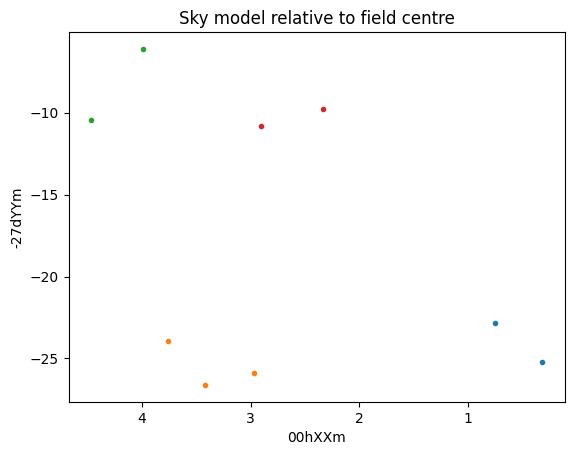

In [3]:
"""Determine pierce points: coordinates through the ionospheric phase
screen for a vector from each sky component to each station."""

# Set the parameters of sky model components

pix = []
ra = []
dec = []
I0 = []
alpha = []

# Components in the MWA EoR0 field used in earlier simulations and analyses
#  - see https://confluence.skatelescope.org/display/SE/Processing+Simulated+SKA1-LOW+Data
#  - "pix" is the index of the DD phase shifts in earlier ORCA simulations (SP-1056)
#  - cat data from GLEAM EGC, I0 = Fitted 200MHz integrated flux density (int_flux_fit_200)
alpha_f0 = 200e6

# calibrator 0
ra.append(0.188993); dec.append(-27.380117); I0.append(1.469851); alpha.append(-0.906332); pix.append(1)
ra.append(0.080540); dec.append(-27.419825); I0.append(0.276939); alpha.append(-0.809829); pix.append(0)
# calibrator 1
ra.append(0.741988); dec.append(-27.431343); I0.append(0.342722); alpha.append(-0.991571); pix.append(2)
ra.append(0.855626); dec.append(-27.443605); I0.append(0.499937); alpha.append(-0.745635); pix.append(3)
ra.append(0.940780); dec.append(-27.399359); I0.append(0.253952); alpha.append(-0.533284); pix.append(4)
# calibrator 3
ra.append(0.583466); dec.append(-27.162710); I0.append(0.218047); alpha.append(-0.589640); pix.append(5)
ra.append(0.725653); dec.append(-27.179884); I0.append(0.198591); alpha.append(-0.903726); pix.append(6)
# calibrator 2
ra.append(0.997671); dec.append(-27.101841); I0.append(0.406418); alpha.append( 0.078379); pix.append(7)
ra.append(1.116799); dec.append(-27.174181); I0.append(0.292849); alpha.append(-0.936806); pix.append(8)
# calibrator 4
# ra.append(1.002078); dec.append(-26.620749); I0.append(0.731255); alpha.append(-0.872251); pix.append(9)
# calibrator 5
# ra.append(0.574386); dec.append(-25.653593); I0.append(1.268702); alpha.append(-0.646113); pix.append(10)
# calibrator 6
# ra.append(357.709045); dec.append(-24.950663); I0.append(7.675314); alpha.append(-0.956932); pix.append(11)

n_components = len(I0)

ra = numpy.array(ra) * units.deg
dec = numpy.array(dec) * units.deg
I0 = numpy.array(I0)
alpha = numpy.array(alpha)
pix = numpy.array(pix, "int")

# Group some or all of the components into direction-dependent calibrators
cal2cmp = []
cal2cmp.append(numpy.array([1, 0], "int"))
cal2cmp.append(numpy.array([3, 2, 4], "int"))
cal2cmp.append(numpy.array([7, 8], "int"))
cal2cmp.append(numpy.array([5, 6], "int"))

n_calibrators = len(cal2cmp)

ax = subplot(111)
for cal in range(n_calibrators):
    cmp = cal2cmp[cal]
    plot((ra[cmp]-ra0).value/15*60, (dec[cmp]-dec0).value*60, f".C{cal}")
ax.set_title("Sky model relative to field centre")
ax.set_xlabel(f"{ra0.value/15:02.0f}hXXm")
ax.set_ylabel(f"{dec0.value:03.0f}dYYm")
ax.invert_xaxis()

# Determine central pierce points for the centre of the array through the tangent plane
# These set the relative position of pierce points from different sky components

# Height of the screen in metres
h_iono = 300e3

azimuth0, elevation0 = hadec_to_azel(
    times[0] - ra0.to(units.rad).value,
    dec0.to(units.rad).value,
    emptyvis.configuration.location.lat.rad,
)
d0 = h_iono * numpy.tan(numpy.pi / 2 - elevation0)
x0 = d0 * numpy.sin(azimuth0)
y0 = d0 * numpy.cos(azimuth0)
log.info(f"ra0 = {ra0}, dec0 = {dec0}")

x_cmp = numpy.empty(n_components)
y_cmp = numpy.empty(n_components)
log.info("Offsets:")
for cmp in range(n_components):
    azimuth, elevation = hadec_to_azel(
        times[0] - ra[cmp].to(units.rad).value,
        dec[cmp].to(units.rad).value,
        emptyvis.configuration.location.lat.rad,
    )
    d = h_iono * numpy.tan(numpy.pi / 2 - elevation)
    x_cmp[cmp] = d * numpy.sin(azimuth)
    y_cmp[cmp] = d * numpy.cos(azimuth)
    log.info(
        " - component %d: ra,dec offsets = %+5.2f, %+5.2f deg, xy = %7.1f, %7.1f m",
        cmp,
        (ra[cmp] - ra0).to(units.deg).value,
        (dec[cmp] - dec0).to(units.deg).value,
        x_cmp[cmp] - x0,
        y_cmp[cmp] - y0,
    )

# Now calculate the pierce point for component-station pairs, all of which
# must be bounded in the phase screen.

x_stn = low_config.xyz.data[:, 0]
y_stn = low_config.xyz.data[:, 1]

x_pp = numpy.array([])
y_pp = numpy.array([])
for cmp in range(n_components):
    x_pp = numpy.append(x_pp, x_cmp[cmp] + x_stn)
    y_pp = numpy.append(y_pp, y_cmp[cmp] + y_stn)

# centre the cluster of pierce points at zero
x_pp -= (numpy.amax(x_pp) + numpy.amin(x_pp)) / 2
y_pp -= (numpy.amax(y_pp) + numpy.amin(y_pp)) / 2

### Set up the phase screen

A phase screen that encompasses all of the pierce points between stations and radio sources with high spatial resolution has too many vertices for the eigen approach of decompose_phasescreen. Instead, generate a coarse phase screen and then interpolate to higher resolution using the midpoint displacement method. This adds extra phase variation during interpolation to maintain Kolmogorov turbulence at the finer spatial scales.

initial resolution = 448 m, need to divide by 2**6 to reach 7 m
final resolution = 7 m, final grid = 1281 x 1281 pixels
Phase screen min = -17.5 deg
Phase screen max = +17.5 deg


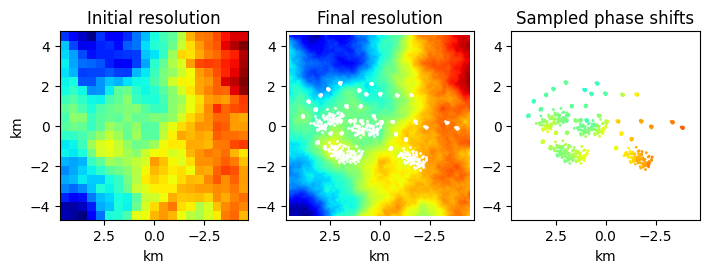

In [4]:
"""Generate a regular 2D phase screen for all of the pierce points"""

# Set parameters for the final, high resolution phase screen
#  - resolution of screen (metres)
res = 7.0
#  - width of screen (metres). Here it is square but it could be rectangular
screen_width = 1.001 * max(
    numpy.amax(x_pp) - numpy.amin(x_pp),
    numpy.amax(y_pp) - numpy.amin(y_pp),
)

# Generate a coarse Nside x Nside grid of ionospheric phase shifts with
# Kolmogorov turbulence

# Width of the coarse screen (pixels)
Nside0 = 21

# Will successively halve the resolution n_interp times, so figure out what
# n_interp and the initial coarse resolution need to be
res0_min = screen_width / (Nside0 - 1)
n_interp = numpy.ceil(numpy.log2(res0_min / res)).astype("int")
res0 = res * 2 ** n_interp

# Coordaintes of the coarse grid
x = numpy.arange(Nside0) * res0
y = numpy.arange(Nside0) * res0
xx, yy = numpy.meshgrid(x, y)

# Decompose the convariance matrix of pierce point phase shifts obeying
# the ionospheric structure function at some nominal frequency
screen_f0 = 150e6
r_0 = 20e3          #  structure function diffractive scale at screen_f0
beta = 5.0 / 3.0    #  structure function exponent
[evec_matrix, sqrt_evals] = decompose_phasescreen(xx, yy, r_0, beta)
n_points = xx.size

# Generate a random realisation of the coarse phase screen
screen0 = evec_matrix @ (sqrt_evals * numpy.random.randn(n_points))
screen0 = screen0.reshape(xx.shape)

# Successively interpolate the screen n_interp times
print(
    f"initial resolution = {res0:.0f} m,",
    f"need to divide by 2**{n_interp} to reach {res:.0f} m",
)

Nside = Nside0
res = res0
screen = screen0.copy()
for _ in range(n_interp):
    screen = interpolate_phasescreen(screen)
    screen = displace_phasescreen(screen, res, r_0, beta)
    Nside = 2 * Nside - 1
    res /= 2

print(
    f"final resolution = {res:.0f} m,",
    f"final grid = {Nside} x {Nside} pixels",
)

# Set some phase screen constants and extract the phase shifts from the grid
wl_scaling = screen_f0 / emptyvis.frequency.data
i = ((x_pp + screen_width / 2) / res).astype("int")
j = ((y_pp + screen_width / 2) / res).astype("int")
pp_phase = screen[i, j]

figure()
subplots_adjust(left=0, right=1)
cmap = colormaps["jet"]

ax1 = subplot(131, aspect="equal")
ax1.set_title("Initial resolution")
ax1.set_xlabel("km")
ax1.set_ylabel("km")
x = res0 * numpy.arange(-(Nside0 // 2), Nside0 // 2 + 1) / 1e3
y = res0 * numpy.arange(-(Nside0 // 2), Nside0 // 2 + 1) / 1e3
pc = pcolor(x, y, screen0.T * 180.0 / numpy.pi, cmap=cmap)
ax1.invert_xaxis()

ax2 = subplot(132, aspect="equal")
ax2.set_title("Final resolution")
ax2.set_xlabel("km")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
x = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
y = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
pc = pcolor(x, y, screen.T * 180.0 / numpy.pi, cmap=cmap)
scatter(x_pp/1e3, y_pp/1e3, s=1, c="w")

ax3 = subplot(133, aspect="equal")
ax3.set_title("Sampled phase shifts")
ax3.set_xlabel("km")
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())
scatter(
    x_pp/1e3, y_pp/1e3, s=1, c=pp_phase * 180.0 / numpy.pi, cmap=cmap,
    vmin=numpy.amin(screen) * 180.0 / numpy.pi,
    vmax=numpy.amax(screen) * 180.0 / numpy.pi,
)

print(f"Phase screen min = {numpy.amin(screen) * 180.0 / numpy.pi:+.1f} deg")
print(f"Phase screen max = {numpy.amax(screen) * 180.0 / numpy.pi:+.1f} deg")

### Quick plot to get a feel of the level direction dependence in the phase shifts

The important quantity for calibration and imaging is the relative phase shift between stations. Direction-dependent calibration is needed when the relative phase shifts change between components

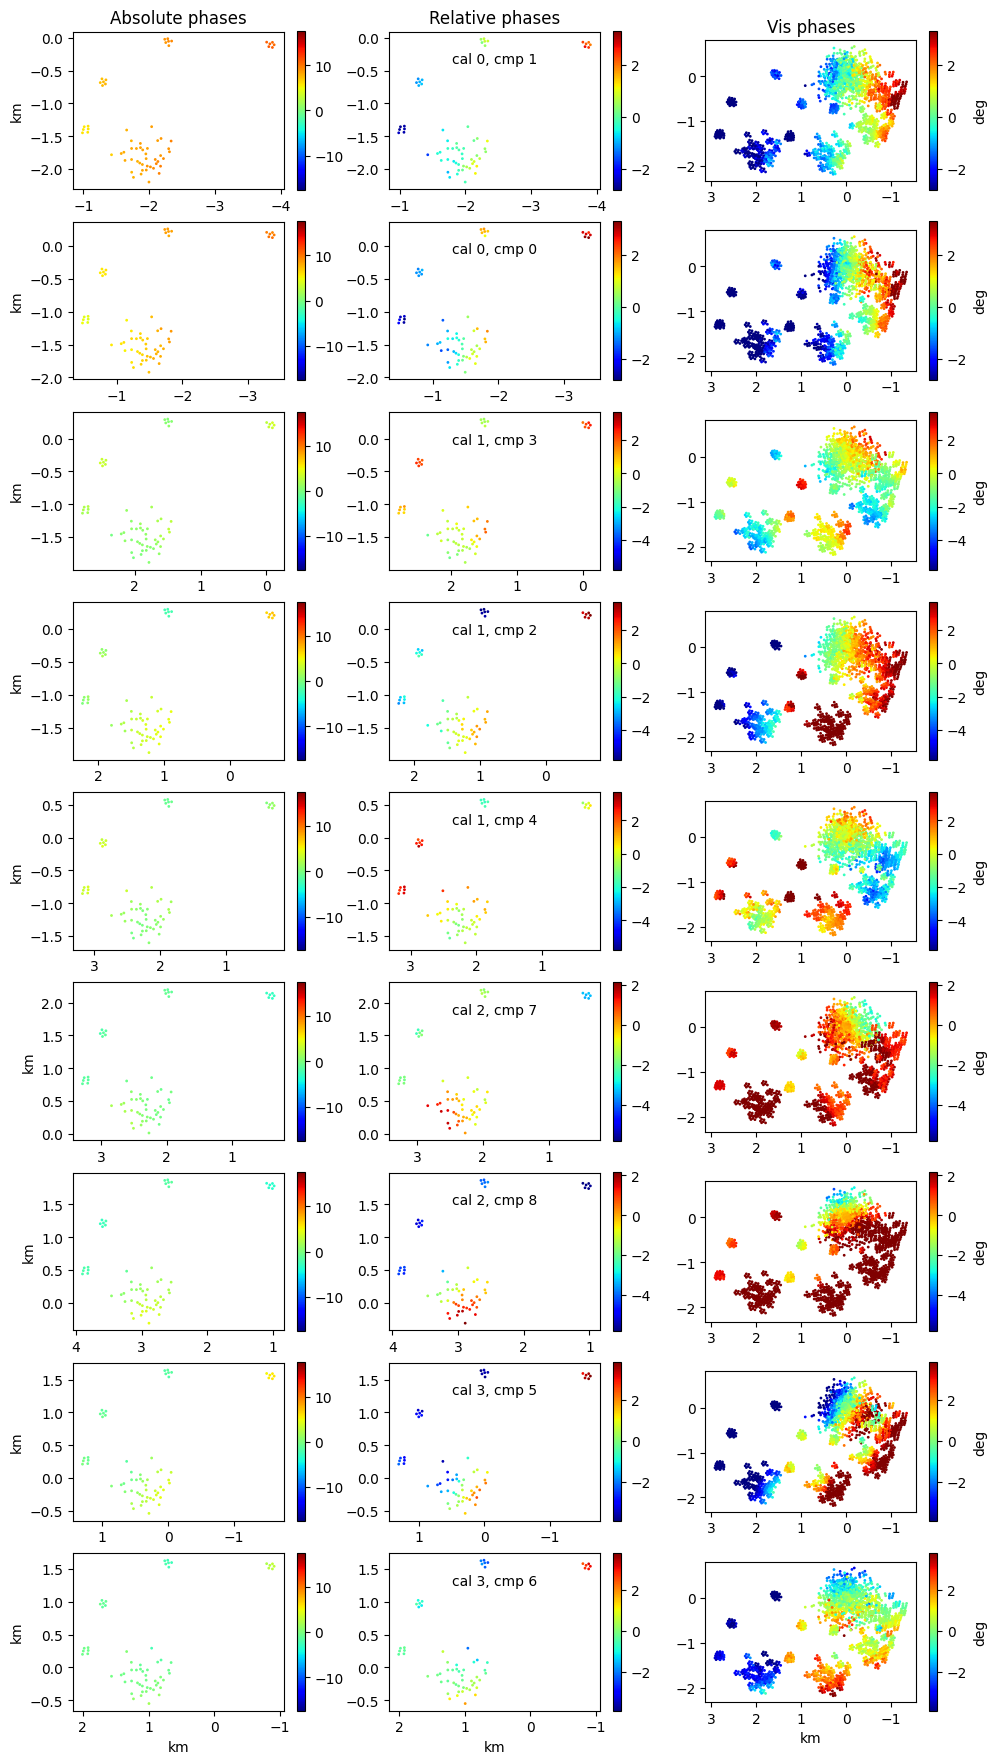

In [5]:
u = x_stn[emptyvis.antenna1.data] - x_stn[emptyvis.antenna2.data]
v = y_stn[emptyvis.antenna1.data] - y_stn[emptyvis.antenna2.data]

cidx = 0
for cal in range(n_calibrators):

    subplots_adjust(left=0, right=1.4, bottom=-2.5, top=1)

    # precalculate some common colour settings
    cmin = +1e12
    cmax = -1e12
    vmin = +1e12
    vmax = -1e12
    for cmp in cal2cmp[cal]:
        cmp_idx0 = cmp * n_stations
        cmp_phase = pp_phase[cmp_idx0 : cmp_idx0 + n_stations]
        vis_phase = (
            cmp_phase[emptyvis.antenna1.data]
            - cmp_phase[emptyvis.antenna2.data]
        )
        cmin = min(cmin, min(cmp_phase - numpy.mean(cmp_phase[cluster_id==0])) * 180.0 / numpy.pi)
        cmax = max(cmax, max(cmp_phase - numpy.mean(cmp_phase[cluster_id==0])) * 180.0 / numpy.pi)
        vmin = min(vmin, min(vis_phase) * 180.0 / numpy.pi)
        vmax = max(vmax, max(vis_phase) * 180.0 / numpy.pi)

    for cmp in cal2cmp[cal]:

        cmp_idx0 = cmp * n_stations
        cmp_phase = pp_phase[cmp_idx0 : cmp_idx0 + n_stations]

        ax = subplot(n_components, 3, 3*cidx+1, aspect="equal")
        scatter(
            x_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
            y_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
            c=cmp_phase * 180.0 / numpy.pi,
            s=1, cmap=cmap,
            vmin=numpy.amin(screen) * 180.0 / numpy.pi,
            vmax=numpy.amax(screen) * 180.0 / numpy.pi,
        )
        ax.invert_xaxis()
        cb = colorbar()
        if cidx == 0: title("Absolute phases")
        if cidx == n_components - 1: xlabel("km")
        ylabel("km")

        ax = subplot(n_components, 3, 3*cidx+2, aspect="equal")
        scatter(
            x_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
            y_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
            c=(cmp_phase-numpy.mean(cmp_phase[cluster_id==0])) * 180.0 / numpy.pi,
            s=1, cmap=cmap,
            vmin=cmin,
            vmax=cmax,
        )
        ax.invert_xaxis()
        ax.add_artist(AnchoredText(f"cal {cal}, cmp {cmp}", frameon=False, loc=9, pad=1))
        cb = colorbar()
        if cidx == 0: title("Relative phases")
        if cidx == n_components - 1: xlabel("km")

        vis_phase = (
            cmp_phase[emptyvis.antenna1.data]
            - cmp_phase[emptyvis.antenna2.data]
        )

        ax = subplot(n_components, 3, 3*cidx+3, aspect="equal")
        scatter(u/1e3, v/1e3, s=1, c=vis_phase * 180.0 / numpy.pi, cmap=cmap, vmin=cmin, vmax=cmax)
        ax.invert_xaxis()
        cb = colorbar(label="deg")
        if cidx == 0: title("Vis phases")
        if cidx == n_components - 1: xlabel("km")

        cidx += 1

Set up a plotting function for the results

In [6]:
def rms(x):
    return numpy.sqrt(numpy.mean(x**2))

def plot_fit(pp_phase, cmp_idx0, gain_table):

    r2d = 180.0 / numpy.pi

    # cmap = colormaps["bone"]
    # cmap = colormaps["viridis"]
    cmap = colormaps["jet"]

    # Get the fitted phase shifts, scaled to the screen frequency
    chan = 0
    time = 0
    pol = 0
    fit = (
        numpy.angle(gain_table.gain.data[time, :, chan, pol, pol])
        / wl_scaling[chan]
    )

    # Extract the relevant phases and do phase referencing
    cmp_phase = pp_phase[cmp_idx0 : cmp_idx0 + n_stations]
    # Phase referencing against a single station:
    # ptrue = cmp_phase - cmp_phase[0]
    # pfit = fit - fit[0]
    # or against all of the core stations:
    ptrue = cmp_phase - numpy.mean(cmp_phase[cluster_id==0])
    pfit = fit - numpy.mean(fit[cluster_id==0])

    c0a = numpy.amin(ptrue * r2d)
    c0b = numpy.amax(ptrue * r2d)

    x = x_pp[cmp_idx0 : cmp_idx0 + n_stations]
    y = y_pp[cmp_idx0 : cmp_idx0 + n_stations]

    # subplots_adjust(left=0, right=1, bottom=-0.15, top=0.85)
    subplots_adjust(left=0, right=1.8, bottom=0.2, top=1)

    ca = subplot(131, aspect="equal")
    ca.xaxis.set_ticklabels([])
    phase = numpy.array(ptrue).flatten() * r2d
    scatter(x/1e3, y/1e3, c=phase, s=10, marker='.', cmap=cmap, vmin=c0a, vmax=c0b)
    ca.invert_xaxis()
    title("true, RMS=%.3f deg" % rms(phase))
    xlabel("east (km)")
    ylabel("north (km)")
    colorbar(shrink=0.5)
    grid()

    ca = subplot(132, aspect="equal")
    ca.xaxis.set_ticklabels([])
    ca.yaxis.set_ticklabels([])
    phase = numpy.array(pfit).flatten() * r2d
    c0a = numpy.amin(phase)
    c0b = numpy.amax(phase)
    scatter(x/1e3, y/1e3, c=phase, s=10, marker='.', cmap=cmap, vmin=c0a, vmax=c0b)
    ca.invert_xaxis()
    title("fit, RMS=%.3f deg" % rms(phase))
    xlabel("east (km)")
    colorbar(shrink=0.5)
    grid()

    ca = subplot(133, aspect="equal")
    phase = numpy.array(pfit.flatten() - ptrue.flatten()).flatten() * r2d
    max_err = numpy.amax(abs(phase))
    scatter(x/1e3, y/1e3, c=phase, s=10, marker='.', cmap=cmap)
    ca.invert_xaxis()
    title("fit error, RMS=%.3f deg" % rms(phase))
    xlabel("east (km)")
    colorbar(shrink=0.5)
    grid()

### Calibrate each direction in isolation to get a feel for model errors

The following plots show the true phase shifts on the left (the weighted average over components), the fitted phase shifts in the middle, and the associated errors on the right, with a separate row for each of the four calibrators.

The errors on the right arise mainly from two effects. The first type of error comes from the direction-dependent phase variations across the sky components of each calibrator. These could be reduced by further separation of components into more calibrators. The second type of error is model error, since the solver can only contrain low-order Zernike basis functions across each cluster. Note, for instance, the high-frequency noise-like quality of errors in the central cluster. Model errors are investigated in YAN-1326. Neither type of error is considered further here, the results just indicate the best-case error floor that can be hoped for in a peel loop.

INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]


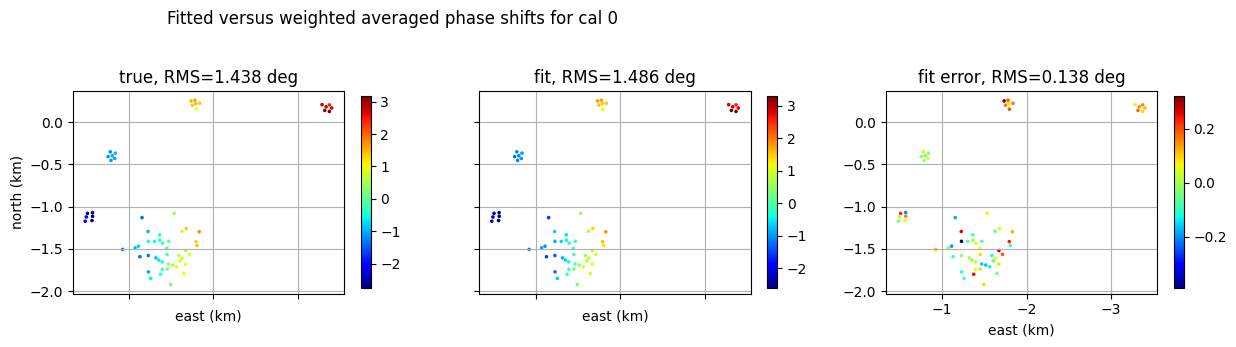

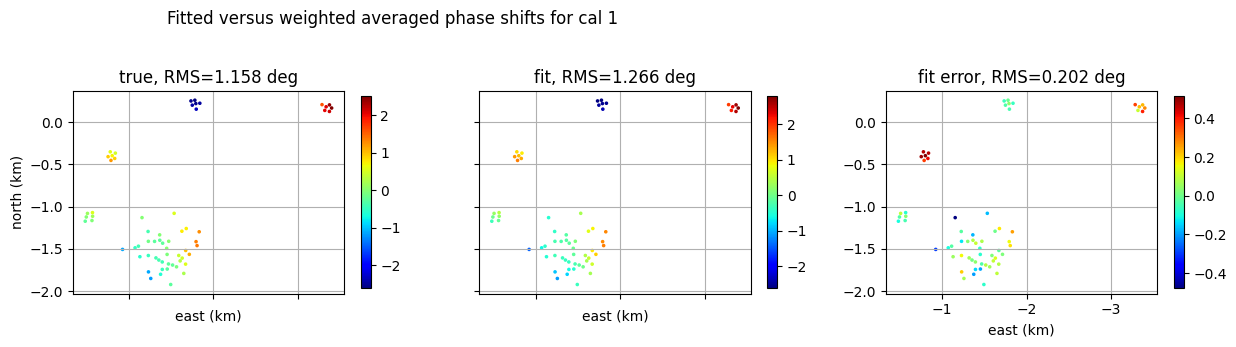

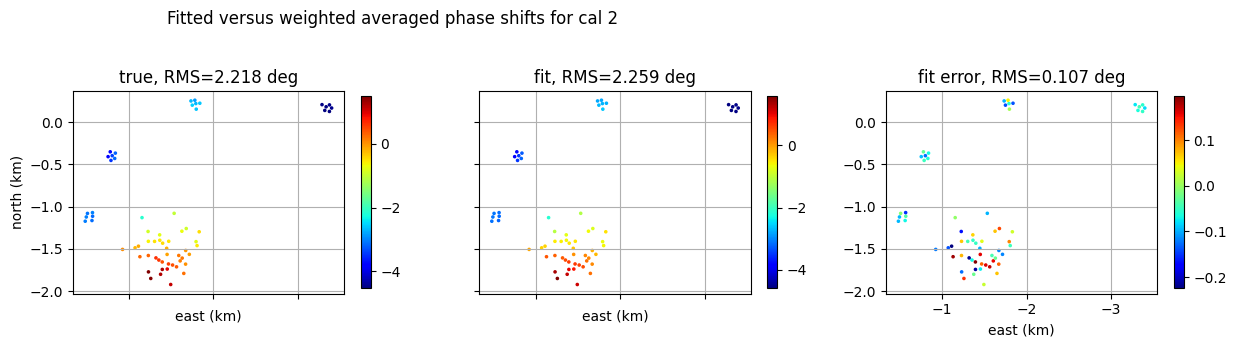

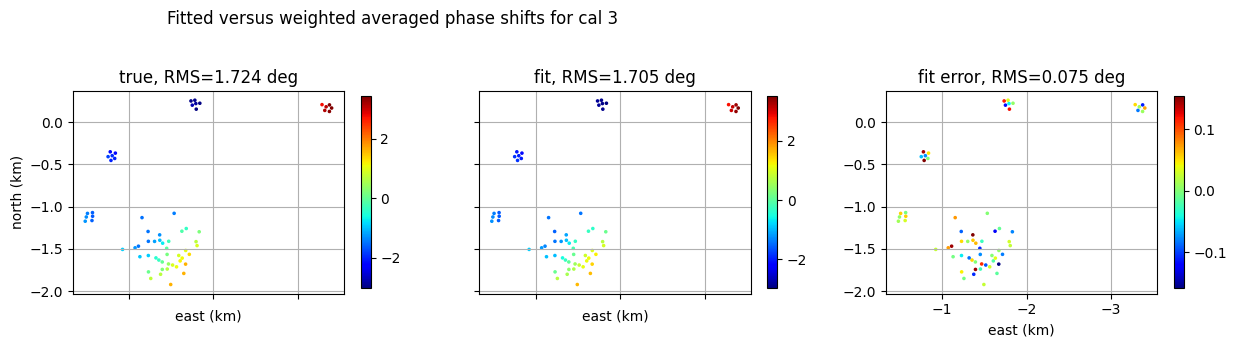

In [7]:
"""Check calibration directions in isolation"""

# Compare against the weighted average phase shift across all calibrator components
# V = M * exp(- i * 2*pi * wl * fit)
# imag(V) ~ - M * 2*pi * wl * fit
# dV      ~ - M * 2*pi * wl
# imag(V*conj(dV))  ~ |2*pi * wl * M|^2 * fit
# real(dV*conj(dV)) = |2*pi * wl * M|^2
wl = const.c.value / emptyvis.frequency.data

for cal in range(n_calibrators):

    # Initialise the visibility data and model
    emptyvis.vis.data *= 0.0
    vis = emptyvis.copy(deep=True)
    modelvis = emptyvis.copy(deep=True)

    pp_phase_ave = numpy.zeros(n_stations)
    pp_phase_wgt = 0.0

    # Predict components one at a time to allow for direction dependence
    for cmp in cal2cmp[cal]:

        # Predict this component into temporary storage
        # emptyvis data should be overwritten but set to zero anyway
        emptyvis.vis.data *= 0.0
        flux_density = I0[cmp] * (frequency / alpha_f0) ** alpha[cmp]
        tmpvis = dft_skycomponent_visibility(
            emptyvis,
            SkyComponent(
                direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
                frequency=frequency,
                name=f"component-{cmp}",
                flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
                polarisation_frame=PolarisationFrame("stokesI"),
            ),
        )

        # Calculate visibility phase shifts for this component
        cmp_idx0 = cmp * n_stations
        wgt = numpy.mean((flux_density * wl)**1)
        pp_phase_ave += wgt * pp_phase[cmp_idx0 : cmp_idx0 + n_stations]
        pp_phase_wgt += wgt
        vis_phase = (
            pp_phase[cmp_idx0 + vis.antenna1.data]
            - pp_phase[cmp_idx0 + vis.antenna2.data]
        )
        # Add predicted visibilities to the main arrays
        #  - need to handle time and polarisation better than this...
        time = 0
        pol = 0
        modelvis.vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]
        vis.vis.data[time, :, :, pol] += (
            tmpvis.vis.data[time, :, :, pol] * numpy.exp(
                1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
            )
        )

    pp_phase_ave /= pp_phase_wgt

    # Solve cluster parameters and convert to gain_table station phase shifts
    gain_table = solve_ionosphere(
        vis,
        modelvis,
        low_config.xyz.data,
        cluster_id,
    )

    fig = figure()
    fig.suptitle(f"Fitted versus weighted averaged phase shifts for cal {cal}")
    plot_fit(pp_phase_ave, 0, gain_table)

### Form the full sky model and calibrate each direction in a peel loop

In the final demonstration below, the solver is called multiple times for each calibrator in a peel loop. It follows a standard strategy of:
1. subtract everything from the sky that we know of,
2. loop over calibrators, solving for phase updates and adjusting the residual visibilies,
3. go back to the first calibrator and loop over the calibrators again,
4. exit if any convergence criteria are reached.

The main point here is that the solver is picking up the direction-dependent variations between the calibrators, and the size and structure of the errors are similar to the completely separate case above.

INFO:yan-1312:===========================
INFO:yan-1312:cycle 1 of 3
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:yan-1312:Fit error: 0.138936 deg, vis RMS: 0.046613
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:yan-1312:Fit error: 0.245082 deg, vis RMS: 0.040232
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:yan-1312:Fit error: 0.199641 deg, vis RMS: 0.030465
INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]
INFO:yan-1312:Fit error: 0.284942 deg, vis RMS: 0.027470
INFO:yan-1312:===========================
INFO:yan-1312:cycle 2 of 3
INFO:func-pyth

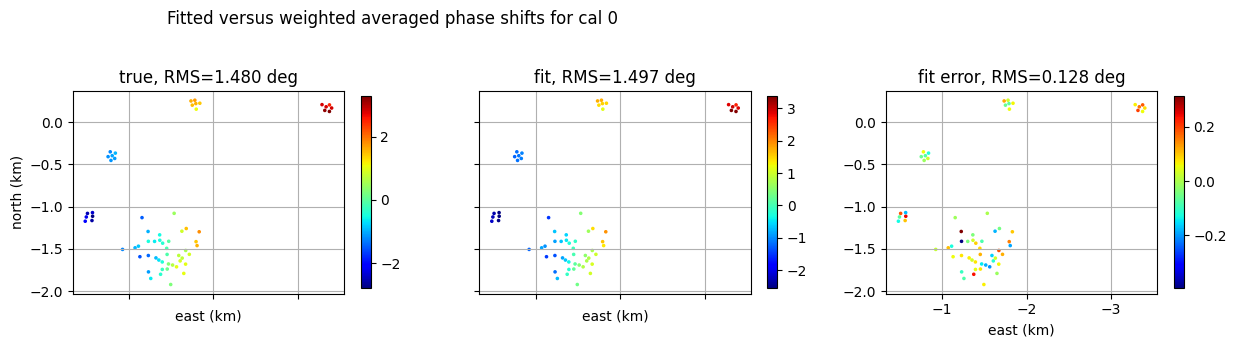

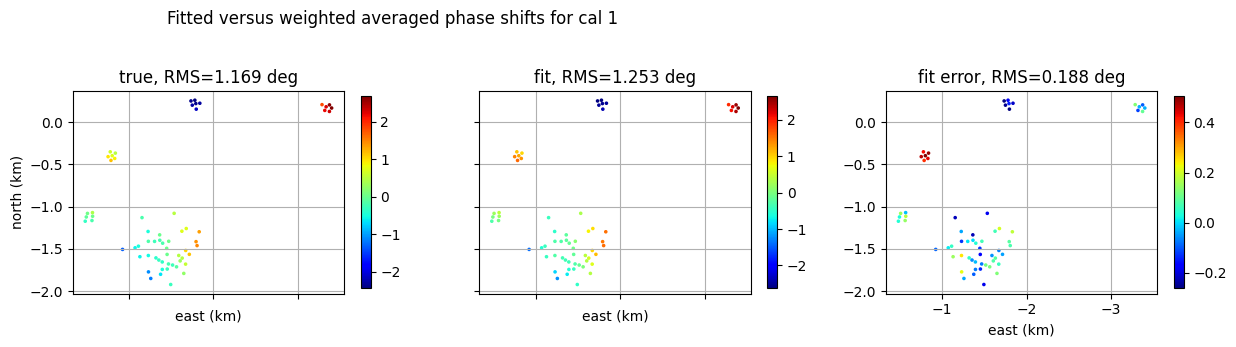

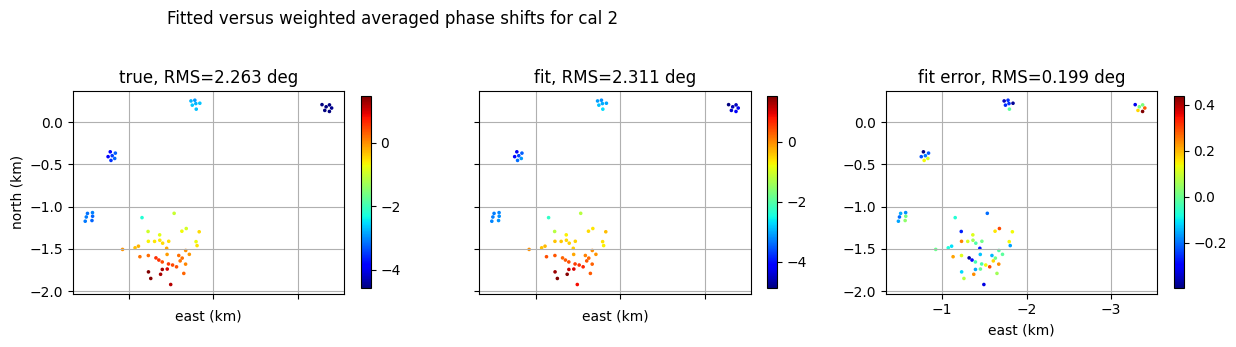

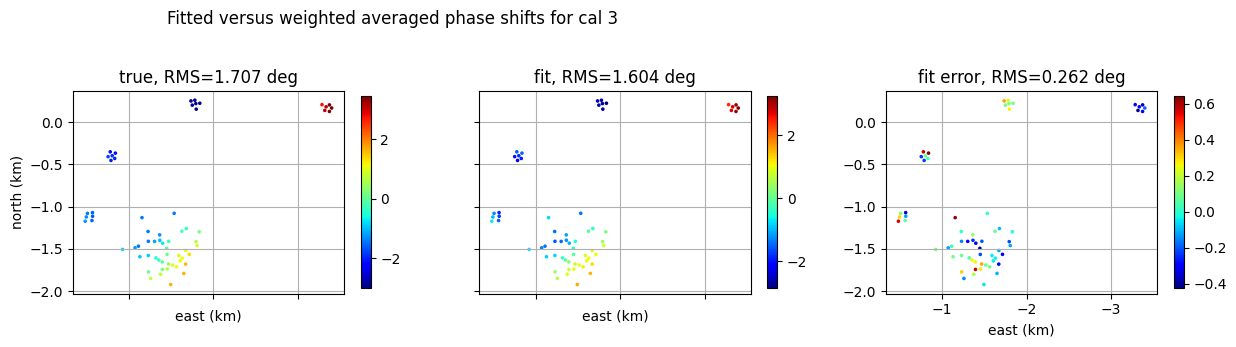

In [8]:
""" 1. Predict the "true" visibilties and the full sky model """

# Initialise the visibility data 
emptyvis.vis.data *= 0.0
vis = emptyvis.copy(deep=True)
modelvis = emptyvis.copy(deep=True)

# Predicted components one at a time to allow for direction dependence
for cmp in range(n_components):

    # Predict this component into temporary storage
    # emptyvis data should be overwritten but set to zero anyway
    emptyvis.vis.data *= 0.0
    flux_density = I0[cmp] * (frequency / alpha_f0) ** alpha[cmp]
    tmpvis = dft_skycomponent_visibility(
        emptyvis, 
        SkyComponent(
            direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
            frequency=frequency,
            name=f"component-{cmp}",
            flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
            polarisation_frame=PolarisationFrame("stokesI"),
        ),
    )

    # Calculate visibility phase shifts for this component
    cmp_idx0 = cmp * n_stations
    vis_phase = (
        pp_phase[cmp_idx0 + vis.antenna1.data]
        - pp_phase[cmp_idx0 + vis.antenna2.data]
    )
    # Add predicted visibilities to the main arrays
    #  - need to handle time and polarisation better than this...
    time = 0
    pol = 0
    modelvis.vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]
    vis.vis.data[time, :, :, pol] += (
        tmpvis.vis.data[time, :, :, pol] * numpy.exp(
            1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
        )
    )

""" 2. Subtract model from vis """

vis.vis.data -= modelvis.vis.data

""" 3. Generate model visibilities for each calibration direction """

# Could have accumulated these in step 1 but this seems a bit more readable
# Only need to accumulate once and then update incrementally in cal loops

# modelcal[cal] is the contribution of calibrator cal to modelvis
modelcal = [[] for _ in range(n_calibrators)]
# also store a separate weighted sum of input phase shifts for each cal
pp_cal = [[] for _ in range(n_calibrators)]

for cal in range(n_calibrators):

    # Initialise a visibility model for this calibrator
    emptyvis.vis.data *= 0.0
    modelcal[cal] = emptyvis.copy(deep=True)

    pp_phase_ave = numpy.zeros(n_stations)
    pp_phase_wgt = 0.0

    # Predict components one at a time to allow for direction dependence
    for cmp in cal2cmp[cal]:

        # Predict this component into temporary storage
        # emptyvis data should be overwritten but set to zero anyway
        emptyvis.vis.data *= 0.0
        flux_density = I0[cmp] * (frequency / alpha_f0) ** alpha[cmp]
        tmpvis = dft_skycomponent_visibility(
            emptyvis,
            SkyComponent(
                direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
                frequency=frequency,
                name=f"component-{cmp}",
                flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
                polarisation_frame=PolarisationFrame("stokesI"),
            ),
        )

        cmp_idx0 = cmp * n_stations
        wgt = numpy.mean((flux_density * wl)**2)
        pp_phase_ave += wgt * pp_phase[cmp_idx0 : cmp_idx0 + n_stations]
        pp_phase_wgt += wgt

        # Add predicted visibilities to the model
        #  - need to handle time and polarisation better than this...
        time = 0
        pol = 0
        modelcal[cal].vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]

    pp_cal[cal] = pp_phase_ave / pp_phase_wgt

""" 4. Step through directions and calibrate on each """

n_cycles = 3
cal_table = [[] for _ in range(n_calibrators)]

for cycle in range(n_cycles):

    log.info("===========================")
    log.info("cycle %d of %d", cycle + 1, n_cycles)
    
    for cal in range(n_calibrators):

        # Add the current model back to the visibilties.
        # This step could be avoided as the model is just subtracted again in
        # solve_ionosphere. Would need to change solve_ionosphere to accept
        # residual visibilties.
        vis.vis.data += modelcal[cal].vis.data

        # Solve cluster parameters and convert to gain table phase shifts
        gain_table = solve_ionosphere(
            vis,
            modelcal[cal],
            low_config.xyz.data,
            cluster_id,
        )

        # Update cummulative gain table phase shifts
        if cycle == 0:
            cal_table[cal] = gain_table
        else:
            cal_table[cal].gain.data *= gain_table.gain.data

        # Now subtract the updated model
        vis.vis.data -= modelcal[cal].vis.data

        # Log some stats
        fit = numpy.angle(cal_table[cal].gain.data[0, :, 0, 0, 0]) / wl_scaling[0]
        pfit = fit - numpy.mean(fit[cluster_id==0])
        ptrue = pp_cal[cal] - numpy.mean(pp_cal[cal][cluster_id==0])
        log.info(
            "Fit error: %f deg, vis RMS: %f",
            numpy.sqrt(numpy.mean((pfit - ptrue)**2)) * 180 / numpy.pi,
            numpy.sqrt(numpy.mean(numpy.abs(vis.vis.data)**2)),
        )

        if cycle == n_cycles - 1:
            fig = figure()
            fig.suptitle(f"Fitted versus weighted averaged phase shifts for cal {cal}")
            plot_fit(pp_cal[cal], 0, cal_table[cal])
